# **Ф35**: Модуль прогнозирования эффектов трансформации территории в масштабах населенного пункта и региона

## 1. Подготовка исходных данных

- `service_types` -- таблица типов сервисов.
- `blocks` -- слой городских кварталов с разной информацией.
- `acc_mx` -- матрица доступности городских кварталов.

In [1]:
import pandas as pd
import geopandas as gpd
from blocksnet.config import log_config

log_config.set_disable_tqdm(True)
log_config.set_logger_level('ERROR')

service_types_df = pd.read_pickle('./data/service_types.pickle')
blocks_gdf = pd.read_pickle('./data/blocks.pickle')
acc_mx = pd.read_pickle('./data/acc_mx.pickle')

In [2]:
blocks_gdf['population'] = blocks_gdf['population'].fillna(0)

### 1.1. Подготовка списка сервисов

Нужны только те списки сервисов, у которых есть `infrastructure_type` и у которых известно имя `blocksnet`

In [3]:
service_types_df = service_types_df[~service_types_df['infrastructure_type'].isna()].copy()
service_types_df = service_types_df[~service_types_df['blocksnet'].isna()].copy()
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,[8],park
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[2, 4]",school
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university


## 2A. Эффекты ДО

Если `scenario_id` является `base_scenario`, то мы не обязаны ничего оптимизировать и просто должны посчитать обеспеченность as is.

In [4]:
from blocksnet.relations.accessibility import get_accessibility_context

def _get_accessibility_context(blocks : pd.DataFrame, acc_mx : pd.DataFrame, accessibility : float) -> list[int]:
  project_blocks = blocks[blocks['is_project']].copy()
  context_blocks = get_accessibility_context(acc_mx, project_blocks, accessibility, out=False, keep=True)
  return list(context_blocks.index)

In [5]:
from blocksnet.analysis.provision import competitive_provision
from blocksnet.config import service_types_config

def _assess_provision(blocks : pd.DataFrame, acc_mx : pd.DataFrame, service_type : str) -> gpd.GeoDataFrame:
  _, demand, accessibility = service_types_config[service_type].values()
  context_ids = _get_accessibility_context(blocks, acc_mx, accessibility)
  capacity_column = f'capacity_{service_type}'
  if capacity_column not in blocks.columns:
    blocks_df = blocks[['geometry','population']].fillna(0)
    blocks_df['capacity'] = 0
  else:
    blocks_df = blocks.rename(columns={capacity_column:'capacity'})[['geometry', 'population', 'capacity']].fillna(0)
  prov_df, _ = competitive_provision(blocks_df, acc_mx, accessibility, demand)
  prov_df = prov_df.loc[context_ids].copy()
  return blocks[['geometry']].join(prov_df, how='right')

### Получаем слои с оценкой обеспеченности

In [6]:
from blocksnet.config import service_types_config

prov_gdfs = {}
for st_id in service_types_df.index:
    st_name = service_types_df.loc[st_id,'blocksnet']
    column = f'capacity_{st_name}'
    _,demand,accessibility = service_types_config[st_name].values()
    prov_gdf = _assess_provision(blocks_gdf.rename(columns={f'capacity_{st_id}': f'capacity_{st_name}'}), acc_mx, st_name)
    prov_gdfs[st_name] = prov_gdf

Например:

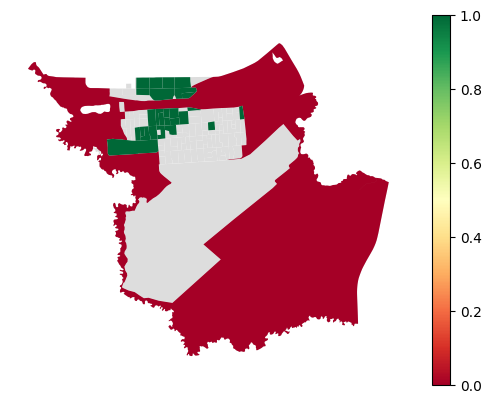

In [8]:
ax = prov_gdfs['park'].plot(color='#ddd')
prov_gdfs['park'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

### Получаем общие оценки обеспеченности

In [9]:
from blocksnet.analysis.provision import provision_strong_total

prov_totals_before = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_before[st_name] = total

В итоге:

In [10]:
prov_totals_before

{'park': 0.9904610492845787,
 'beach': 0.0,
 'kindergarten': 0.0,
 'school': 0.0,
 'university': 0.0,
 'polyclinic': 0.0,
 'pharmacy': 0.0,
 'hospital': 0.0,
 'library': 0.9666666666666667,
 'museum': 0.0,
 'theatre': 1.0,
 'cinema': 0.0,
 'mall': 1.0,
 'stadium': 1.0,
 'cafe': 0.0,
 'restaurant': 0.9411764705882353,
 'bar': 0.0,
 'pitch': 1.0,
 'playground': 0.0,
 'police': 0.0,
 'train_station': 0.15151515151515152,
 'supermarket': 0.0,
 'market': 1.0,
 'bank': 0.98989898989899,
 'veterinary': 0.0,
 'hotel': 1.0,
 'religion': 0.0,
 'sanatorium': 0.0}

### Результат

В результате имеем следующие данные для ситуации ДО:
- `prov_gdfs : dict[str, gpd.GeoDataFrame]` -- слои с оценкой обеспеченности по выбранным типам сервисов
- `prov_totals : dict[str, float | None]` -- оценки обеспеченности

## 2B. Эффекты ПОСЛЕ

Если `scenario_id` не является `base_scenario`, то для заданного пользователем функционального зонирования мы должны предсказать возможную обеспеченность (по сути, лучший случай).

### Подготовка данных

Для каждого `infrastructure_type` также добавим весовой коэффициент, чтобы отдать предпочтение базовым сервисам, а остальные добавлять по возможности.

In [11]:
INFRASTRUCTURES_WEIGHTS = {
    'basic': 0.5714,
    'additional': 0.2857,
    'comfort': 0.1429
}

service_types_df['infrastructure_weight'] = service_types_df['infrastructure_type'].map(INFRASTRUCTURES_WEIGHTS) * service_types_df['weight']
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet,infrastructure_weight
service_type_id,,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,[8],park,0.11428
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach,0.07145
21,500.0,basic,0.2,None,7.0,NaN,61.0,[2],kindergarten,0.11428
22,800.0,basic,0.2,None,15.0,NaN,120.0,"[2, 4]",school,0.11428
27,5000.0,comfort,0.2,None,60.0,NaN,13.0,"[4, 10, 17]",university,0.02858


Готовим словарь, какой квартал в какой ФЗ переводим.

`blocks_lus : dict[int, LandUse]`

In [ ]:
from blocksnet.enums import LandUse

blocks_lus = blocks_gdf.loc[blocks_gdf['is_project'],'land_use']
blocks_lus = blocks_lus[~blocks_lus.isna()]
blocks_lus = blocks_lus.to_dict()
blocks_lus[0] = LandUse.RESIDENTIAL #FIXME УДАЛИТЬ!!! ЭТО ДЛЯ ПРИМЕРА

Инициализируем экземпляр класса оптимизатора.

In [45]:
from blocksnet.optimization.services import (
    TPEOptimizer,
    WeightedObjective,
    WeightedConstraints,
    Facade,
    GradientChooser,
    AreaSolution
)

var_adapter = AreaSolution(blocks_lus)

facade = Facade(
    blocks_lu=blocks_lus,
    blocks_df=blocks_gdf,
    accessibility_matrix=acc_mx,
    var_adapter=var_adapter,
)


Добавляем информацию о существующих типах сервисов.

**ВАЖНО**: если сервиса нет в слое кварталов, просто добавляем `DataFrame` с нулевыми `capacity` для него. Ведь мы же должны что-то расставлять.

ЛИБО

Можно попробовать на этапе сборки слоя просто добавлять пустой столбец, чтобы не терять.

In [46]:
for st_id, row in service_types_df.iterrows():
    st_name = row['blocksnet']
    st_weight = row['infrastructure_weight']
    st_column = f'capacity_{st_id}'
    df = blocks_gdf.rename(columns={st_column: 'capacity'})[['capacity']].fillna(0)
    facade.add_service_type(st_name, st_weight, df)

### Оптимизация

Запускаем оптимизатор...

In [47]:
MAX_EVALS = 1000 # сколько раз будет считаться обеспеченность. Можно ставить и большее число, если ориентируемся только на время
MAX_RUNS = 1000 # сколько итераций будет считаться в оптимизации. Так же ставим 1000 без проблем
TIMEOUT = 1 * 60 # сколько по времени будет считаться оптимизация (в секундах). Если уже прошло данное время, досчитается итерация и отдаст ответ

In [48]:
services_weights = service_types_df.set_index('blocksnet')['infrastructure_weight'].to_dict()

objective = WeightedObjective(num_params=facade.num_params, facade=facade, weights=services_weights, max_evals=MAX_EVALS)

constraints = WeightedConstraints(num_params=facade.num_params, facade=facade)

tpe_optimizer = TPEOptimizer(
    objective=objective, constraints=constraints, vars_chooser=GradientChooser(facade, facade.num_params, num_top=5)
)

best_x, best_val, perc, func_evals = tpe_optimizer.run(max_runs=MAX_RUNS, timeout=TIMEOUT, initial_runs_num=1)

[I 2025-10-13 03:25:20,017] A new study created in memory with name: no-name-49e557ab-8d0e-44ee-ac42-7bcd756cb030


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-10-13 03:25:20,872] Trial 0 finished with value: 0.532769784985964 and parameters: {'x_0': 3520, 'x_1': 18500, 'x_2': 20000, 'x_3': 0, 'x_4': 0, 'x_5': 12000, 'x_6': 0, 'x_7': 0, 'x_8': 2800, 'x_9': 1000, 'x_10': 10000, 'x_11': 5000, 'x_12': 100, 'x_13': 200, 'x_14': 60, 'x_15': 150, 'x_16': 50, 'x_17': 700, 'x_18': 0, 'x_19': 3000, 'x_20': 450, 'x_21': 0, 'x_22': 24000, 'x_23': 9100}. Best is trial 0 with value: 0.532769784985964.
[I 2025-10-13 03:25:21,363] Trial 1 finished with value: 0.5329777684851147 and parameters: {'x_0': 7833, 'x_1': 25668, 'x_2': 20459, 'x_3': 806, 'x_4': 2583, 'x_5': 14621, 'x_6': 3704, 'x_7': 3, 'x_8': 2839, 'x_9': 1031, 'x_10': 10013, 'x_11': 5050, 'x_12': 391, 'x_13': 217, 'x_14': 95, 'x_15': 432, 'x_16': 56, 'x_17': 707, 'x_18': 2373, 'x_19': 3088, 'x_20': 635, 'x_21': 1945, 'x_22': 24971, 'x_23': 9220}. Best is trial 1 with value: 0.5329777684851147.
[I 2025-10-13 03:25:21,825] Trial 2 finished with value: 0.5075088509954715 and parameters: {'x_

### Результат

- Если для данного данного сервиса нет в списке доступных для данного `land_use`, он не оптимизируется и не учитывается.
- То что не оптимизировали, надо пересчитать, особенно если прибавилось население. Добавляем это население по возможности

In [49]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

prov_gdfs = {}
for st_id in service_types_df.index:
    st_name = service_types_df.loc[st_id, 'blocksnet']
    if st_name in facade._chosen_service_types:
        prov_df = facade._provision_adapter.get_last_provision_df(st_name)
        prov_gdf = blocks_gdf[['geometry']].join(prov_df, how='right')
        prov_gdfs[st_name] = prov_gdf
    else:
        column = f'capacity_{st_name}'
        _,demand,accessibility = service_types_config[st_name].values()
        df = blocks_gdf.rename(columns={f'capacity_{st_id}': f'capacity_{st_name}'})
        df.loc[blocks_gdf.is_project, f'capacity_{st_name}'] = 0
        df.loc[blocks_gdf.is_project, 'population'] = solution_population_df.loc[blocks_gdf.is_project, 'population']
        prov_gdf = _assess_provision(df, acc_mx, st_name)
        prov_gdfs[st_name] = prov_gdf

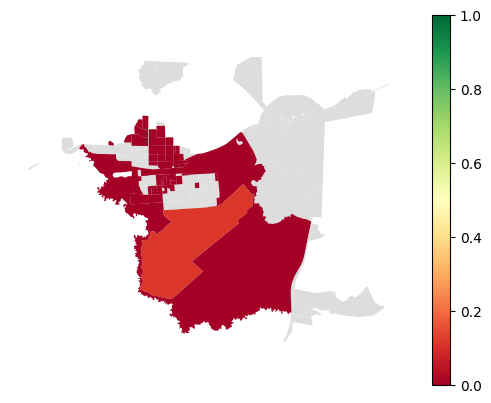

In [50]:
ax = prov_gdfs['hospital'].plot(color='#ddd')
prov_gdfs['hospital'].plot('provision_strong', ax=ax, vmin=0, vmax=1, cmap='RdYlGn', legend=True).set_axis_off()

Чиселки обеспеченности для графика

In [53]:
prov_totals_after = {}
for st_name, prov_gdf in prov_gdfs.items():
    if prov_gdf.demand.sum() == 0:
        if prov_gdf.capacity.sum() > 0:
            total = 1.0
        else:
            total = 0.0
    else:
        total = float(provision_strong_total(prov_gdf))
    prov_totals_after[st_name] = total

Если какой-то сервис тут отсутствует, можно брать с `base_scenario` (?? я подумаю еще правильно ли это)

In [54]:
prov_totals_after

{'park': 0.07477397978721632,
 'beach': 0.0,
 'kindergarten': 0.003305238803503553,
 'school': 0.005247580865221133,
 'university': 0.09342301943198804,
 'polyclinic': 0.009727626459143969,
 'pharmacy': 0.006744225257123588,
 'hospital': 0.1078167115902965,
 'library': 0.998780487804878,
 'museum': 0.15873015873015872,
 'theatre': 1.0,
 'cinema': 0.18094089264173704,
 'mall': 1.0,
 'stadium': 1.0,
 'cafe': 0.0025290844714213456,
 'restaurant': 0.011893870082342177,
 'bar': 0.010041420861051838,
 'pitch': 1.0,
 'playground': 1.0,
 'police': 0.030349013657056147,
 'train_station': 0.4884601294419343,
 'supermarket': 0.0010115570391725462,
 'market': 0.6076072426783328,
 'bank': 0.9998752806186081,
 'veterinary': 0.05332239540607055,
 'hotel': 1.0,
 'religion': 0.3240279162512463,
 'sanatorium': 0.0}

<Axes: >

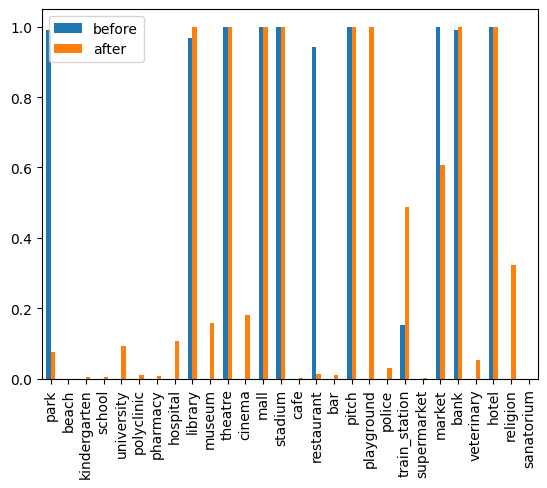

In [55]:
provisions_df = pd.DataFrame.from_dict({'before': prov_totals_before, 'after': prov_totals_after})
provisions_df.plot.bar()

# **Ф26**: Модуль ценностно-ориентированного моделирования программ развития населенного пункта.

Берем результат из пункта `2.b` и разворачиваем его на кварталы: куда что ставить:

- `block_id` -- номер квартала, куда ставим.
- `service_type` -- тип сервиса.
- `site_area` -- занимаемая площадь квартала.
- `build_floor_area` -- занимаемая площадь зданий.
- `capacity` -- суммарная емкость типа застройки
- `count` -- количество расставляемых объектов данного типа в данном квартале

In [56]:
solution_df = facade.solution_to_services_df(best_x)
solution_df

,block_id,service_type,site_area,build_floor_area,capacity,count
0,0,kindergarten,3520.0,240.0,80,1
6,0,school,18500.0,2500.0,250,1
13,0,university,20000.0,5000.0,500,1
20,0,polyclinic,0.0,400.0,50,1
22,0,pharmacy,0.0,25.0,40,1
25,0,hospital,3500.0,660.0,110,1
26,0,hospital,12000.0,2400.0,400,1
31,0,library,0.0,207.0,230,1
35,0,museum,0.0,400.0,200,1
38,0,theatre,2800.0,2000.0,800,1


Отсюда нужно взять `population` для каждого квартала (`index` здесь это тот же индекс из `blocks : pd.DataFrame`)

In [57]:
solution_population_df = facade.get_solution_area_df(best_x)
solution_population_df

,population,build_floor_area,living_area,footprint_area
0,396210.0,4.274876e+06,4.245109e+06,759978.005897
1,0.0,6.405045e+07,0.000000e+00,0.000000
2,0.0,2.194551e+08,0.000000e+00,0.000000
3,0.0,3.320482e+08,0.000000e+00,0.000000
4,0.0,6.468579e+05,0.000000e+00,0.000000
...,...,...,...,...
456,0.0,1.288098e+04,0.000000e+00,0.000000
457,0.0,8.803568e+02,0.000000e+00,0.000000
458,0.0,5.518729e+02,0.000000e+00,0.000000
459,0.0,7.127272e+02,0.000000e+00,0.000000
